# Facilities KPI Scorecard
This notebook serves as a repository of public-facing KPIs for the Department of General Services' Facilities Division. The purpose of this notebook is to have, in a single public place, the entire pipeline for calculating the division's three KPIs that are based in Archibus. Those KPIs are:

1. % of Corrective Maintenance Work Requests Completed On Time
2. % of Preventive Maintenance Work Requests Completed On Time
3. Preventive Maintenace to Corrective Maintenance Ratio

Part of the intention of this notebook is to build _transparency_ and _reproducibility_ by capturing the entire end-to-end process used to calculate these metrics in one place.

## Setup

### Import packages

In [1]:
# workhorse modules
import pandas as pd
import numpy as np
from datetime import timedelta, datetime
import re
from pathlib import Path
import seaborn as sns
import datadotworld as dw
import matplotlib.pyplot as plt
from faker import Faker

from matplotlib.dates import DateFormatter
import matplotlib.ticker as ticker

# local utility functions
from utils import (
    add_cm_benchmarks,
    add_fiscal_year,
    set_pd_params,
    tidy_up_df,
    cast_dtypes,
    glue_date_time,
    compute_days_to_completion,
    compute_days_open,
    consolidate_prob_types,
    compute_pm_cm,
    compute_pm_cm_by_month,
    compute_kpi_table,
    compute_kpi_table_by_month,
)

from vis_utils import set_plot_params, pointplot_with_barplot

### Set pandas options
This makes Pandas print all rows and columns to the output when requested.

In [2]:
set_pd_params()
set_plot_params()
pd.options.mode.chained_assignment = None  # default='warn'

### Import the work order data from Data.World
This data is a copy of Archibus's `wrhwr` table stored at DGS's account on Data.World. To see the exact query used to generate the input data, see `/sql/input_for_FMD_KPIs.sql`.

In [3]:
# kpis_raw = dw.query(
#     dataset_key="dgsbpio/auditfinding3", query="select * from dash_benchmarks_20210423"
# ).dataframe
kpis_path = Path.cwd() / "data" / "dash_benchmarks_20210426.csv"
kpis_raw = pd.read_csv(
    kpis_path, parse_dates=["date_completed", "date_requested", "date_closed"]
)
kpis_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107523 entries, 0 to 107522
Data columns (total 19 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   wr_id                   107523 non-null  int64         
 1   status                  107523 non-null  object        
 2   description             98908 non-null   object        
 3   supervisor              84843 non-null   object        
 4   date_completed          97550 non-null   datetime64[ns]
 5   date_requested          107523 non-null  object        
 6   date_closed             97312 non-null   object        
 7   fy_request              107523 non-null  int64         
 8   role_name               100087 non-null  object        
 9   building_name           107172 non-null  object        
 10  b_number                107172 non-null  object        
 11  primary_type            107523 non-null  object        
 12  problem_type            107523

In [4]:
print(f"The work orders dataframe has {kpis_raw.shape[0]:,} rows.")

kpis_raw.sample(3, random_state=444)[["wr_id", "problem_type", "date_requested"]]

The work orders dataframe has 107,523 rows.


,wr_id,problem_type,date_requested
36918,40102,OTHER,00:00.0
3794,112376,SERV/CUSTODIAL,00:00.0
8295,140316,ELEVATOR,00:00.0


## Data cleaning
For the purposes of this project, DGS is keeping the cleaning stage very simple. We're not attempting to remove duplicates or outliers, both of which involve relatively complex operations. 

### Basic cleaning
- removes white spaces in strings to facilitate matching, 
- drops rows with no problem type, or rows created by a test,
- renames a few columns

In [5]:
kpis_raw.head()

,wr_id,status,description,supervisor,date_completed,date_requested,date_closed,fy_request,role_name,building_name,b_number,primary_type,problem_type,PM_type,calendar_month_request,calendar_month_close,days_to_completion,days_open,benchmark
0,19800,RMI,Need someone to make the necessary repairs to ...,NaN,NaT,00:00.0,NaN,2015,GATEKEEPER-RESTRICTED - BOC ...,6400 Pulaski Highway Front Gate/Guard Office,B00166,HVAC,HVAC,NaN,2015-01,NaN,NaN,1569,30.0
1,21365,RMI,LABOR AND MATERIALS TO ADJUST OUTSIDE AIR DAMP...,NaN,NaT,00:00.0,NaN,2015,GATEKEEPER - BOC ...,Howard Peters Rawlings Conservatory,B06225,HVAC,HVAC,NaN,2015-01,NaN,NaN,1554,30.0
2,24961,RMI,Please provide labor & materials to replace se...,NaN,NaT,00:00.0,NaN,2015,GATEKEEPER - BOC ...,Oliver Senior Center,P00119,ELECTRICAL,ELEC/LIGHT,NaN,2015-03,NaN,NaN,1516,14.0
3,27301,I,The retaining wall that leads to the upper lot...,TERREL.CHESSON,2021-05-03,00:00.0,NaN,2015,GATEKEEPER - BOC ...,Baltimore City Police North Eastern District,B00025,OTHER-EXTERNAL,OTHER,NaN,2015-03,NaN,116.0,1502,14.0
4,27353,Com,PROVIDE EMERGENCY REPAIR TO THE SPRINKLER SYST...,DARRYL.RAGIN,2021-05-03,00:00.0,NaN,2015,GATEKEEPER - BOC ...,Mount Pleasant Ice Arena,B02055,HVAC,HVAC,NaN,2015-03,NaN,643.0,1502,30.0


In [6]:
def cast_dtypes(df):
    df = df.copy()
    df["wr_id"] = df["wr_id"].astype(int)
    df["date_completed"] = df["date_completed"].astype("datetime64[ns]")
    return df


def tidy_up_df(df):
    df = df.copy()
    df = df.rename(mapper={"prob_type": "problem_type"}, axis=1)
    df = df.loc[:, ~df.columns.duplicated()]
    df = df.dropna(subset=["wr_id", "problem_type"])
    df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
    # df = df.applymap(lambda x: np.nan if x == "NULL" else x)
    # df["supervisor"] = df["supervisor"].apply(lambda x: "NULL" if x != x else x)
    cond_valid = ~df["problem_type"].str.contains("TEST")
    # df = df[cond_valid]
    df["status"] = df["status"].replace("A", "AA", regex=False)
    return df

In [7]:
wr_tidy = tidy_up_df(kpis_raw)
wr_tidy["year"] = wr_tidy["calendar_month_request"].str[:4].astype(int)
wr_tidy["month"] = wr_tidy["calendar_month_request"].str[-2:].astype(int)
wr_tidy["month_start"] = pd.to_datetime(wr_tidy[["year", "month"]].assign(DAY=1))


print(f"The tidied work orders dataframe has {len(wr_tidy):,} rows.")
print(f"By tidying the data, we have removed {len(kpis_raw) - len(wr_tidy):,} rows.")

The tidied work orders dataframe has 107,523 rows.
By tidying the data, we have removed 0 rows.


### Drop canceled and rejected work orders
The data comes to us with many canceled work orders. Those shouldn't count against us as not having been completed on time. So we drop them here. 

In [8]:
# drop rows that were canceled
cond_valid = ~wr_tidy["status"].isin(["Can", "Rej", "R"])

wr_valid = wr_tidy[cond_valid]

print(
    f"By dropping canceled work orders, we have removed {len(wr_tidy) - len(wr_valid):,} rows."
)

By dropping canceled work orders, we have removed 4,020 rows.


### Add fiscal year
There are different ways to assign a fiscal year to a work request. Currently, we're doing it by the fiscal year in which the work request was closed. Other options would include the fiscal year of the request. 


In [9]:
# wr_fy = add_fiscal_year(wr_valid, assign_fy_on="closure")
# wr_fy = wr_fy.rename(columns={"fiscal_year": "fy_close"})

# print(f"{len(wr_valid)}, {len(wr_fy)}")

After assigning the fiscal year, we can drop work requests from FY15 and older. 

In [10]:
wr_fy = wr_valid.copy()
cond_fy = wr_fy["fy_request"].isin(range(2016, 2022))
wr_fy = wr_fy[cond_fy]

In [11]:
def compute_is_on_time(row):
    row["is_on_time"] = row["days_to_completion"] <= row["benchmark"]
    return row


wr_fy = wr_fy.dropna(subset=["days_to_completion", "benchmark"]).apply(
    compute_is_on_time, axis=1
)

In [12]:
wr_fy['PM_type'].value_counts()

BLDG INSPECTION     1403
GENERATOR TEST      1010
ELEVATOR TEST        973
HVAC INSPECTION      839
BASEMENT INSPECT     689
FUEL TANK TEST       517
HEATING LEVELS       414
HEAT CHECK TEST      180
UTILITY ROOMS        113
FLOOR BUFFING         62
HVAC FILTER CHAN      21
KITCHEN PM            15
EXTERMINATION         10
Name: PM_type, dtype: int64

In [13]:
wr_fy[["is_on_time", "days_to_completion"]].sample(12)

,is_on_time,days_to_completion
37728,True,0.0
49084,True,2.0
59176,False,57.0
79575,False,78.0
49213,True,0.0
92712,True,1.0
8446,True,0.0
53048,True,0.0
105556,False,66.0
97243,False,15.0


### Anonymize names

In [17]:
def split_names(row):
    if type(row["supervisor"]) == float:
        row["supervisor"] = "NULL"
    if "." in row["supervisor"]:
        full_name = row["supervisor"].split(".")
        row["supervisor_fname"] = full_name[0]
        row["supervisor_lname"] = full_name[1]
    if row["supervisor"] == "NULL":
        row["supervisor_fname"] = "NULL"
        row["supervisor_lname"] = "NULL"
    return row


wr_names = wr_fy.apply(split_names, axis=1)

In [18]:
def replace_names(df, faker):
    # empty string values as nan
    df["supervisor"] = df["supervisor"].replace("NULL", np.nan)
    # name replacement dictionary
    fname_replacements = {
        name: faker.first_name().upper().replace(" ", "")
        for name in df["supervisor_fname"].unique()
        if name is not np.nan
    }
    lname_replacements = {
        name: faker.last_name().upper().replace(" ", "")
        for name in df["supervisor_lname"].unique()
        if name is not np.nan
    }

    # apply replacement
    df = df.replace(
        {"supervisor_fname": fname_replacements, "supervisor_lname": lname_replacements}
    )
    df["supervisor_anon"] = df["supervisor_fname"] + "." + df["supervisor_lname"]
    df = df.drop(columns=["supervisor_fname", "supervisor_lname"])
    df["supervisor_anon"] = df["supervisor_anon"].replace(np.nan, "NULL")
    return df


fake = Faker()
wr_names = replace_names(wr_names, fake)

print(f"Length: {len(wr_names)}")

wr_names[["supervisor_anon"]].head()

Length: 70109


,supervisor_anon
71,EMILY.MARTINEZ
72,EMILY.MARTINEZ
73,EMILY.MARTINEZ
76,EMILY.MARTINEZ
77,EMILY.MARTINEZ


In [19]:
wr_names.status.value_counts()

Clo    66031
Com     4068
I          5
HC         2
AA         1
S          1
HMI        1
Name: status, dtype: int64

## KPI: % PMs Completed On Time 
The goal here is to filter the data down to preventive maintenance only, and then show how many are completed on or before the benchmark (21 days).

### Filter to valid PM only, and for relevant fiscal years only
After noticing that many PMs have the status "Can" — meaning they were canceled — we fil

In [14]:
wr_primary = wr_fy.copy()

In [37]:
wr_primary.groupby(["primary_type", "PM_type"])['wr_id'].count().sort_values().sort_index(level=[0], ascending=False, sort_remaining=False)

primary_type        PM_type         
PREVENTIVE_HVAC     HVAC INSPECTION      839
                    HEATING LEVELS       414
                    HEAT CHECK TEST      180
                    HVAC FILTER CHAN      21
PREVENTIVE_GENERAL  BLDG INSPECTION     1403
                    GENERATOR TEST      1010
                    ELEVATOR TEST        973
                    BASEMENT INSPECT     689
                    FUEL TANK TEST       517
                    UTILITY ROOMS        113
                    FLOOR BUFFING         62
                    KITCHEN PM            15
                    EXTERMINATION         10
Name: wr_id, dtype: int64

In [16]:
# this defines which problem types are considered PMs
pm_list = [
    "PREVENTIVE_GENERAL",
    "PREVENTIVE_HVAC",
]

# filter data to PM types only
cond_pm = wr_primary["primary_type"].isin(pm_list)
#cond_pm = wr_primary["problem_type"] == "PREVENTIVE MAINT"
#cond_pm = wr_primary["primary_type"].str.contains("PREVENTIVE")
# apply filter conditions
wr_pm = wr_primary[cond_pm]

print(f"The filtered PMs dataframe has {wr_pm.shape[0]:,} rows.")

The filtered PMs dataframe has 7,359 rows.


In [17]:
cond_fy = wr_pm['fy_request'] < 2021
wr_pm_comp = wr_pm[cond_fy]
pms_by_FY = wr_pm_comp.groupby(["primary_type", "fy_request"])['wr_id'].count()
pms_by_FY = pd.DataFrame(pms_by_FY)
pms_by_FY = pms_by_FY.reset_index()
pms_by_FY

,primary_type,fy_request,wr_id
0,PREVENTIVE_GENERAL,2016,717
1,PREVENTIVE_GENERAL,2017,1077
2,PREVENTIVE_GENERAL,2018,1517
3,PREVENTIVE_GENERAL,2019,1181
4,PREVENTIVE_GENERAL,2020,857
5,PREVENTIVE_HVAC,2016,25
6,PREVENTIVE_HVAC,2017,256
7,PREVENTIVE_HVAC,2018,417
8,PREVENTIVE_HVAC,2019,382
9,PREVENTIVE_HVAC,2020,462


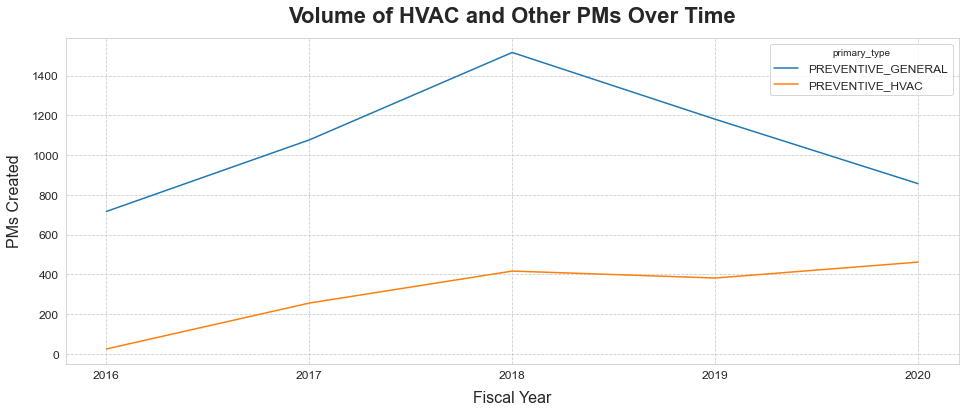

In [18]:
import matplotlib.ticker as ticker

ax = sns.lineplot(data=pms_by_FY, x='fy_request', y='wr_id', hue='primary_type')
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

_ = ax.set(title = "Volume of HVAC and Other PMs Over Time", xlabel="Fiscal Year", ylabel="PMs Created")

#### Compute the benchmark and add `is_on_time` column
Here we tell Python that PMs are on-time if completed in 21 days. 

Then the function `compute_is_on_time` compares the column `days_to_completion` to the benchmark and writes down whether the work request was completed on time. 

In [19]:
wr_pm = wr_pm.dropna(subset=["days_to_completion"])

In [20]:
wr_pm[
    [
        "wr_id",
        "problem_type",
        "primary_type",
        "benchmark",
        "fy_request",
        "calendar_month_request", 
        "month_start",
        "days_to_completion",
        "is_on_time",
        "status",
    ]
].sample(3, random_state=446)

,wr_id,problem_type,primary_type,benchmark,fy_request,calendar_month_request,month_start,days_to_completion,is_on_time,status
71502,93037,PREVENTIVE MAINT,PREVENTIVE_HVAC,21.0,2018,2017-08,2017-08-01,67.0,False,Clo
64834,85734,PREVENTIVE MAINT,PREVENTIVE_GENERAL,21.0,2017,2017-03,2017-03-01,7.0,True,Clo
53077,69864,BUILDING INTERIOR INSPECTION,PREVENTIVE_GENERAL,21.0,2017,2016-07,2016-07-01,0.0,True,Clo


In [21]:
wr_pm['primary_type'].value_counts()

PREVENTIVE_GENERAL    5725
PREVENTIVE_HVAC       1634
Name: primary_type, dtype: int64

#### Group by fiscal year and get % on time
Now that we've stored all this information, we can group by the fiscal year to get each year's KPI, together with a count of how many PMs 

In [22]:
def compute_kpi_table(df, label_for_KPI, label_for_totals):
    df = df.copy()
    table_df = df.groupby("fy_request")[["is_on_time"]].agg(["mean", "count"])
    table_df.columns = table_df.columns.droplevel(0)
    table_df["mean"] = table_df["mean"].apply(lambda x: round(x * 100, 2))
    table_df = table_df.rename(
        columns={"mean": label_for_KPI, "count": label_for_totals}
    )
    return table_df

In [23]:
pm_compliance = compute_kpi_table(wr_pm, "percent_PMs_on_time", "total_PMs")
pm_compliance

,percent_PMs_on_time,total_PMs
fy_request,,
2016,78.84,742
2017,52.89,1333
2018,77.20,1934
2019,51.44,1563
2020,36.39,1319
2021,39.74,468


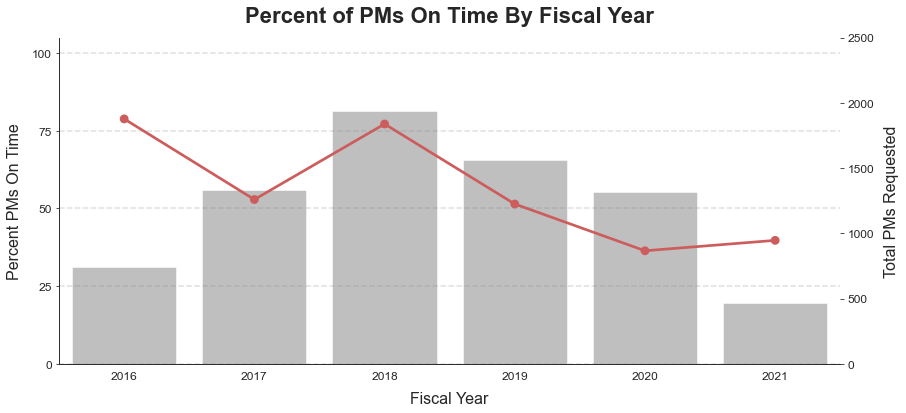

In [24]:
pointplot_with_barplot(
    pm_compliance,
    x="fy_request",
    point_y="percent_PMs_on_time",
    bar_y="total_PMs",
    ymax_bar=2_500,
    ylabel_point="Percent PMs On Time",
    ylabel_bar="Total PMs Requested",
    title="Percent of PMs On Time By Fiscal Year",
)

## KPI: PM:CM Ratio

The two lists below contain the exact same problem types mentioned in last year's scorecard. So we would expect to be able to replicate last year's results closely.

In [25]:
CM_list = [
    "BOILER",
    "CHILLERS",
    "COOLING TOWERS",
    "HVAC",
    "HVAC INFRASTRUCTURE",
    "HVAC|REPAIR",
]

PM_list = [
    "PREVENTIVE_HVAC",
]

### Filter to HVAC rows only

BLDG INSPECTION     1403
GENERATOR TEST      1010
ELEVATOR TEST        973
HVAC INSPECTION      839
BASEMENT INSPECT     689
FUEL TANK TEST       517
HEATING LEVELS       414
HEAT CHECK TEST      180
UTILITY ROOMS        113
FLOOR BUFFING         62
HVAC FILTER CHAN      21
KITCHEN PM            15
EXTERMINATION         10
Name: PM_type, dtype: int64

In [27]:
cond_cm = wr_primary["problem_type"].isin(CM_list)
cond_pm = (wr_primary["primary_type"].isin(PM_list)) | (wr_primary["PM_type"] == 'HVAC INSPECTION')

wr_HVAC = wr_primary[cond_cm | cond_pm]
wr_HVAC["is_pm"] = wr_HVAC["primary_type"].isin(PM_list)

print(
    f"Filtering to HVAC request only takes us from {len(wr_fy):,} rows to {len(wr_HVAC):,} rows."
)

Filtering to HVAC request only takes us from 70,948 rows to 12,980 rows.


In [28]:
wr_HVAC['PM_type'].value_counts()

HVAC INSPECTION     839
HEATING LEVELS      414
HEAT CHECK TEST     180
HVAC FILTER CHAN     21
Name: PM_type, dtype: int64

### Compute all PM/CM stats by fiscal year
First we deploy a custom function that counts the PMs and CMs in each fiscal year and then calculates the PM:CM ratio.

In [29]:
def compute_pm_cm(df, PM_list):
    df = df.copy().sort_values("fy_request")
    df = df.dropna(subset=["days_to_completion"])
    results_df = pd.DataFrame(
        columns=[
            "fiscal_year",
            # "percent_pm",
            "pm_cm_ratio",
            "count_cm",
            "count_pm",
            "count_hvac",
        ]
    )
    for fiscal_year in df["fy_request"].unique():
        results_dict = {}
        df_fy = df[df["fy_request"] == fiscal_year]
        cond_pm = df_fy["is_pm"] == True
        count_pm = len(df_fy[cond_pm])
        count_hvac = len(df_fy)
        count_cm = count_hvac - count_pm
        results_dict["fiscal_year"] = fiscal_year
        results_dict["pm_cm_ratio"] = (count_pm / count_cm) * 100
        results_dict["count_pm"] = count_pm
        results_dict["count_cm"] = count_cm
        results_dict["count_hvac"] = count_hvac
        results_df = results_df.append(results_dict, ignore_index=True)
    results_df[["fiscal_year", "count_cm", "count_pm", "count_hvac"]] = results_df[
        ["fiscal_year", "count_cm", "count_pm", "count_hvac"]
    ].astype("Int64")
    return results_df

In [30]:
pm_cm_results = compute_pm_cm(wr_HVAC, PM_list)

In [31]:
pm_cm_results

,fiscal_year,pm_cm_ratio,count_cm,count_pm,count_hvac
0,2016,1.301406,1921,25,1946
1,2017,11.901441,2151,256,2407
2,2018,17.055215,2445,417,2862
3,2019,18.277512,2090,382,2472
4,2020,25.510768,1811,462,2273
5,2021,9.913793,928,92,1020


### Plot PM:CM ratio by fiscal year

/Users/james/Documents/Bmore/repos/KPI_central/vis_utils.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(yticklabels)


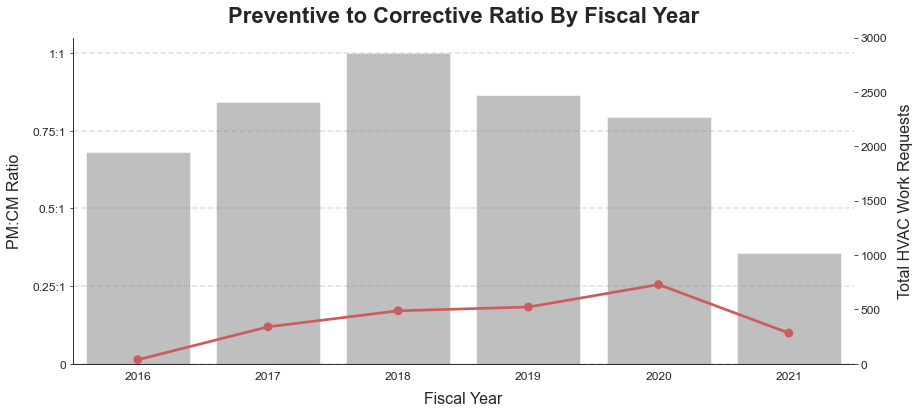

In [32]:
pointplot_with_barplot(
    pm_cm_results,
    x="fiscal_year",
    point_y="pm_cm_ratio",
    bar_y="count_hvac",
    ymax_bar=3_000,
    ylabel_point="PM:CM Ratio",
    ylabel_bar="Total HVAC Work Requests",
    title="Preventive to Corrective Ratio By Fiscal Year",
    yticklabels=["0", "0", "0.25:1", "0.5:1", "0.75:1", "1:1"],
)

### Plot the number of PMs and CMs by fiscal year
We can get a little more insight into what's going on with the ratio by checking out the raw counts of preventive and corrective maintenance work requests by fiscal year. 

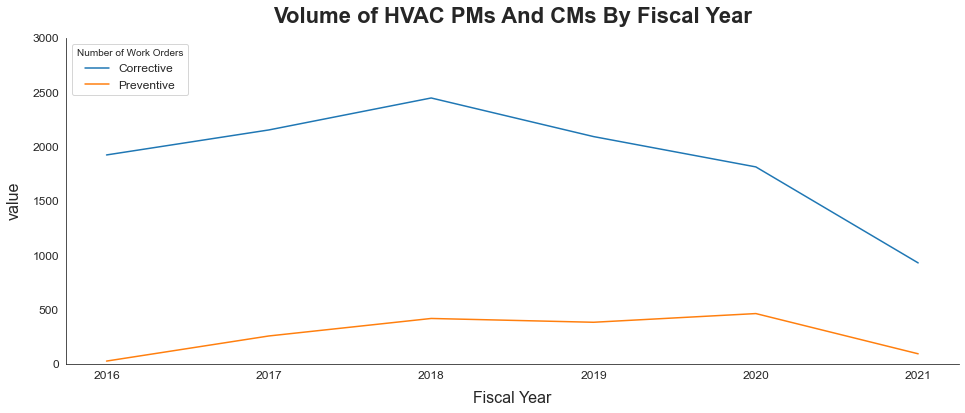

In [33]:
count_plot_data = pd.melt(
    pm_cm_results, id_vars=["fiscal_year"], value_vars=["count_cm", "count_pm"]
)
count_plot_data["value"] = count_plot_data["value"].astype(float)

ax = sns.lineplot(data=count_plot_data, y="value", x="fiscal_year", hue="variable")
new_labels = ["Corrective", "Preventive"]
plt.legend(title="Number of Work Orders", loc="upper left", labels=new_labels)

ax.set(
    title="Volume of HVAC PMs And CMs By Fiscal Year",
    xlabel="Fiscal Year",
    ylim=(0, 3000),
)
sns.despine()

## KPI: Percent of CM Work Requests Completed On-Time
Here are the key facts needed to understand the agency's new method for computing this KPI:

- Only CM problem types are considered, so all PM work orders are dropped.
- The work orders are first assigned a "primary" problem type, which consolidates the number of problem types
- Each of these primary problem types has a benchmark, which is then added to the work request's row
- Finally, the work order is determined to be on-time based on comparing its time to completion to its benchmark

### Filter to get CMs only

In [ ]:
cond_cm = ~wr_primary["primary_type"].str.contains("PREVENTIVE")
consolidated_cms = wr_primary[cond_cm]

print(
    f"Dropping PMs takes us from {len(wr_primary):,} rows to {len(consolidated_cms):,} rows."
)

### Compute whether requests are on time

In [ ]:
cms_on_time = consolidated_cms.dropna(subset=["days_to_completion"])

### Group by fiscal year to get KPI

In [ ]:
cm_compliance = compute_kpi_table(cms_on_time, "percent_CMs_on_time", "total_CMs")
cm_compliance

### Plot % CMs on time by fiscal year

In [ ]:
pointplot_with_barplot(
    cm_compliance,
    x="fy_request",
    point_y="percent_CMs_on_time",
    bar_y="total_CMs",
    ymax_bar=18_000,
    ylabel_point="Percent CMs On Time",
    ylabel_bar="Total CMs",
    title="Percent of CMs On Time By Fiscal Year",
)

## Monthly figures for current FY
First, enter the date of the first day that is outside the range. For example, if we want to show monthly data up to the end of February 2021, set the variable `end_date` to "03-01-2021."

In [38]:
end_date = "05-01-2021"

### PMs on Time (By Month of close)

In [ ]:
def compute_pm_cm_by_month(df, end_date):
    df = df.copy().sort_values("date_closed")
    today = datetime.today()
    cond_current_fy = df["fy_close"] == today.year
    cond_last_month = df["date_closed"] < end_date
    df = df[cond_current_fy & cond_last_month]
    df["year_month"] = df["date_closed"].dt.strftime("%b-%y")
    results_df = pd.DataFrame(
        columns=[
            "year_month",
            "pm_cm_ratio",
            "count_cm",
            "count_pm",
            "count_hvac",
        ]
    )
    for year_month in df["year_month"].unique():
        results_dict = {}
        df_ym = df[df["year_month"] == year_month]
        cond_pm = df_ym["is_pm"] == True
        count_pm = len(df_ym[cond_pm])
        count_hvac = len(df_ym)
        count_cm = count_hvac - count_pm
        results_dict["year_month"] = year_month
        results_dict["pm_cm_ratio"] = (count_pm / count_cm) * 100
        results_dict["count_pm"] = count_pm
        results_dict["count_cm"] = count_cm
        results_dict["count_hvac"] = count_hvac
        results_df = results_df.append(results_dict, ignore_index=True)
    results_df[["count_cm", "count_pm", "count_hvac"]] = results_df[
        ["count_cm", "count_pm", "count_hvac"]
    ].astype(int)
    return results_df.round(2)


def compute_kpi_table_by_month(
    df,
    label_for_KPI=None,
    label_for_totals=None,
    current_fy=2021,
    end_date=None,
    grouping="date_closed",
):
    df = df.copy()
    try:
        end_date = pd.to_datetime(end_date)
    except Exception:
        print(f"Date string {end_date} cannot be converted to a date.")
    # filter to current fy
    cond_current_fy = df["fy_close"] == current_fy
    cond_end_date = df["date_closed"] < end_date
    df = df[cond_current_fy & cond_end_date]
    table_df = (
        df[["wr_id", "date_closed", "is_on_time"]]
        .resample("M", on=grouping)
        .agg({"is_on_time": "mean", "wr_id": "count"})
    )
    table_df["year_month"] = table_df.index.strftime("%b-%y")
    table_df["is_on_time"] = table_df["is_on_time"].apply(lambda x: round(x * 100, 2))
    table_df = table_df.rename(
        columns={"is_on_time": label_for_KPI, "wr_id": label_for_totals}
    )
    return table_df

In [ ]:
pms_on_time_current_fy = compute_kpi_table_by_month(
    wr_pm,
    "percent_PMs_on_time",
    "total_PMs",
    end_date=end_date,
)
pms_on_time_current_fy

In [ ]:
pointplot_with_barplot(
    pms_on_time_current_fy,
    x="year_month",
    point_y="percent_PMs_on_time",
    bar_y="total_PMs",
    ymax_bar=700,
    ylabel_point="% PMs Completed On Time (Red Lines)",
    ylabel_bar="Total PMs Closed (Grey Bars)",
    title="Percent of All PMs Completed On Time By Month (FY21)",
)

### PM:CM Ratio

In [46]:
wr_HVAC[['calendar_month_close']].sample(6)

,calendar_month_close
59070,2016-11
50061,2016-06
76636,2018-02
76486,2020-03
86243,2018-10
87420,2020-03


In [51]:
wr_HVAC = wr_HVAC.drop('date_closed', axis=1)
wr_HVAC = wr_HVAC.dropna(subset=['calendar_month_close'])
wr_HVAC["year"] = wr_HVAC["calendar_month_close"].str[:4].astype(int)
wr_HVAC["month"] = wr_HVAC["calendar_month_close"].str[-2:].astype(int)
wr_HVAC["month_start_close"] = pd.to_datetime(wr_HVAC[["year", "month"]].assign(DAY=1))
wr_HVAC = wr_HVAC.rename(columns={"fy_request": "fiscal_year", "month_start_close": 'date_closed'})

pm_cm_ratio_current_fy = compute_pm_cm_by_month(wr_HVAC, ["list"], end_date=end_date)
pm_cm_ratio_current_fy

,year_month,pm_cm_ratio,count_cm,count_pm,count_hvac
0,Jul-20,0.00,1,0,1
1,Aug-20,0.00,7,0,7
2,Sep-20,0.00,30,0,30
3,Oct-20,0.00,12,0,12
4,Nov-20,0.72,138,1,139
5,Dec-20,25.00,16,4,20
6,Jan-21,1.59,63,1,64
7,Feb-21,0.71,140,1,141
8,Mar-21,7.03,128,9,137
9,Apr-21,56.45,124,70,194


/Users/james/Documents/Bmore/repos/KPI_central/vis_utils.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(yticklabels)


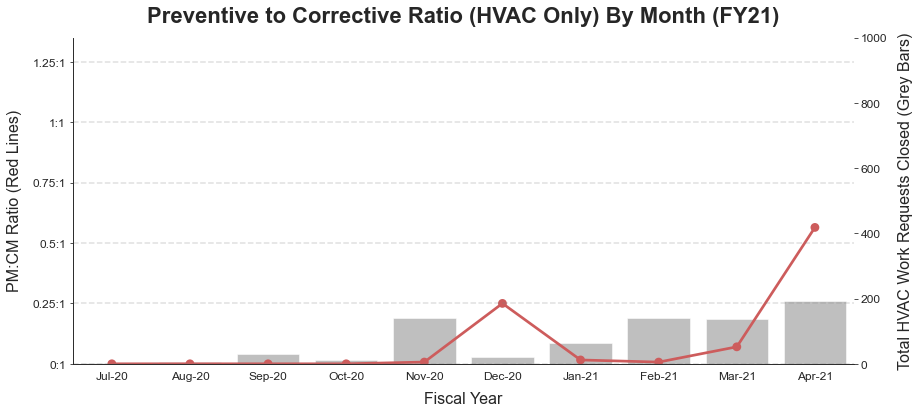

In [52]:
pointplot_with_barplot(
    pm_cm_ratio_current_fy,
    x="year_month",
    point_y="pm_cm_ratio",
    bar_y="count_hvac",
    yaxis_freq=25,
    ymax_point=135,
    ymax_bar=1_000,
    ylabel_point="PM:CM Ratio (Red Lines)",
    ylabel_bar="Total HVAC Work Requests Closed (Grey Bars)",
    title="Preventive to Corrective Ratio (HVAC Only) By Month (FY21)",
    yticklabels=[
        "",
        "0:1",
        "0.25:1",
        "0.5:1",
        "0.75:1",
        "1:1",
        "1.25:1"
    ],
)

In [ ]:
pm_cm_ratio_current_fy = pm_cm_ratio_current_fy.rename(
    columns={"count_cm": "HVAC CMs", "count_pm": "HVAC PMs"}
)

count_plot_data = pd.melt(
    pm_cm_ratio_current_fy, id_vars=["year_month"], value_vars=["HVAC CMs", "HVAC PMs"]
)
count_plot_data = count_plot_data.rename(columns={"variable": "Type of PM"})

ax = sns.pointplot(
    data=count_plot_data, y="value", marker="o", x="year_month", hue="Type of PM"
)
# new_labels = ["Corrective", "Preventive"]
# plt.legend(title="Number of Work Orders", loc="upper left", labels=new_labels)

ax.set(
    title="Volume of HVAC PMs & CMs Closed By Month",
    xlabel="Fiscal Year",
    ylabel="Number of Work Requests Closed",
    ylim=(0, 800),
)
sns.despine()

In [ ]:
cms_on_time_current_fy = compute_kpi_table_by_month(
    cms_on_time,
    "percent_CMs_on_time",
    "total_CMs",
    end_date=end_date,
)

cms_on_time_current_fy

In [ ]:
pointplot_with_barplot(
    cms_on_time_current_fy,
    x="year_month",
    point_y="percent_CMs_on_time",
    bar_y="total_CMs",
    ymax_bar=4_000,
    ylabel_point="% CMs Completed On Time (Red Lines)",
    ylabel_bar="Total CMs Closed (Grey Bars)",
    title="Percent of CMs Completed On Time By Month (FY21)",
)

In [ ]:
def compute_kpi_table_by_month(
    df,
    label_for_KPI=None,
    label_for_totals=None,
    current_fy=2021,
    end_date=None,
    grouping="date_closed",
):
    df = df.copy()
    try:
        end_date = pd.to_datetime(end_date)
    except Exception:
        print(f"Date string {end_date} cannot be converted to a date.")
    # filter to current fy
    cond_current_fy = df["fiscal_year"] == current_fy
    cond_end_date = df["date_closed"] < end_date
    df = df[cond_current_fy & cond_end_date]
    table_df = (
        df[["wr_id", "date_closed", "is_on_time"]]
        .resample("M", on=grouping)
        .agg({"is_on_time": "mean", "wr_id": "count"})
    )
    table_df["year_month"] = table_df.index.strftime("%b-%y")
    table_df["is_on_time"] = table_df["is_on_time"].apply(lambda x: round(x * 100, 2))
    table_df = table_df.rename(
        columns={"is_on_time": label_for_KPI, "wr_id": label_for_totals}
    )
    return table_df

In [ ]:
cms_on_time_by_request = compute_kpi_table_by_month(
    cms_on_time,
    "percent_CMs_on_time",
    "total_CMs",
    end_date=end_date,
    grouping="calend_mon",
)

cms_on_time_by_request

In [ ]:
pointplot_with_barplot(
    cms_on_time_by_request,
    x="year_month",
    point_y="percent_CMs_on_time",
    bar_y="total_CMs",
    ymax_bar=4_000,
    ylabel_point="% CMs Completed On Time (Red Lines)",
    ylabel_bar="Total CMs Closed (Grey Bars)",
    title="Percent of CMs Completed On Time By Month (FY21)",
)

### Percent backlog

In [ ]:
wr_fy["is_backlog"] = wr_fy["days_to_completion"] > 90

In [ ]:
def compute_backlog_table_by_month(
    df, label_for_KPI=None, label_for_totals=None, current_fy=2021, end_date=None
):
    df = df.copy()
    try:
        end_date = pd.to_datetime(end_date)
    except Exception:
        print(f"Date string {end_date} cannot be converted to a date.")
    # filter to current fy
    cond_current_fy = df["fy_close"] == current_fy
    cond_end_date = df["date_closed"] < end_date
    df = df[cond_current_fy & cond_end_date]
    table_df = (
        df[["wr_id", "date_closed", "is_backlog"]]
        .resample("M", on="date_closed")
        .agg({"is_backlog": "mean", "wr_id": "count"})
    )
    table_df["year_month"] = table_df.index.strftime("%b-%y")
    table_df["is_backlog"] = table_df["is_backlog"].apply(lambda x: round(x * 100, 2))
    table_df = table_df.rename(
        columns={"is_backlog": label_for_KPI, "wr_id": label_for_totals}
    )
    return table_df


backlog_plot_data = compute_backlog_table_by_month(
    wr_fy,
    label_for_KPI="percent_backlog",
    label_for_totals="total_work_orders",
    end_date=end_date,
)

In [ ]:
pointplot_with_barplot(
    backlog_plot_data,
    x="year_month",
    point_y="percent_backlog",
    bar_y="total_work_orders",
    ymax_bar=5_000,
    ylabel_point="% Backlog (Red Lines)",
    ylabel_bar="Total WRs Closed (Grey Bars)",
    xlabel="Month",
    title="Percent of WRs Closed that Were Older than 90 Days (FY21)",
)

## Backlog charts

For this we need `wr_durations` because `wr_fy` has assigned the date based on the date of closure.

### Backlog by problem type

In [ ]:
wr_primary[wr_primary["status"] == "Com"][["days_to_completion", "status"]].sample(10)

In [ ]:
wr_primary.status.value_counts()

In [ ]:
def group_backlog_by_col(df, col="primary", backlog_length: int = 90, top_n: int = 10):
    df = df.copy()
    # filter to backlog
    cond_backlog = df["days_to_completion"] >= backlog_length

    cond_status = df["status"].isin(["A", "AA", "Com", "I", "HC", "S"])
    df = df[cond_status & cond_backlog]
    counts_df = pd.DataFrame(
        df.groupby(col)["wr_id"].count().sort_values(ascending=False)
    )
    counts_df = counts_df.head(top_n)
    return counts_df.reset_index()


primary_df = group_backlog_by_col(
    wr_fy,
    col="bl_id",
    backlog_length=10,
)

primary_df

In [ ]:
ax = sns.barplot(data=primary_df, x="bl_id", y="wr_id", color="lightgreen")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment="right")
ax.set(
    title="Size of Backlog By Building Number (> 90 Days)",
    ylabel="Count of work requests",
)
sns.despine()

### Backlog by supervisor

In [ ]:
supervisor_df = group_backlog_by_col(
    backlog_df, col="supervisor_anon", backlog_length=90
)

```Clo    92499 0 Closed
Com     6238 1 Completed
Can     3515 0 Canceled
AA      2821 1 Assigned to Work Order
I        827   Issued and In Process
R        515   Rejected
HC       301   Unknown
S        167   Stopped
Rej      105   Rejected
HMI       83   Unknown 
RMI       82
HL        33
HP        20
HI        11
HA         8
A          3```

In [ ]:
ax = sns.barplot(data=supervisor_df, x="supervisor", y="wr_id", color="lightgreen")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment="right")
ax.set(title="Size of Backlog By Supervisor", ylabel="Count of work requests")
sns.despine()

### Backlog by status

In [ ]:
status_df = group_backlog_by_col(backlog_df, col="status", backlog_length=90)
status_df["status"] = status_df["status"].map(
    {
        "Com": "Complete",
        "AA": "Assigned",
        "I": "Issued/in process",
        "S": "Stopped",
        "HC": "HC",
    }
)

In [ ]:
ax = sns.barplot(data=status_df, x="status", y="wr_id", color="lightgreen")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment="right")
ax.set(title="Size of Backlog By Status (> 90 Days)", ylabel="Count of work requests")
sns.despine()

In [ ]:
backlog_df.columns

In [ ]:
violin_plot_data = backlog_df[
    backlog_df["status"].isin(["A", "AA", "Com", "I", "HC", "S"])
]
ax = sns.violinplot(x="status", y="days_open", data=violin_plot_data)
ax.set(title="Backlog WRs with 'Completed' Status Are Older than Others")
sns.despine()